## Notebook settings

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

## Imports

In [2]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.workspace as dp
import tpvalidator.utilities as utils
import tpvalidator.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid
from tpvalidator.histograms import uproot_hist_mean_std


# Load ADC mean and standard deviation from wafevorm histograms

In [3]:
with uproot.open("../data/vd/ar39/100events/trigger_digits_waves_detsim_vd_ar39.root") as f:

    adc_hists = {}
    for k in f.keys():
        obj_name = k.split('/')[-1]

        if obj_name.startswith('ADCsPlane') or obj_name.startswith('ADCsNoisePlane'):
            adc_hists[obj_name.split(';')[0]] = f[k.split(';')[0]]

print(adc_hists)

{
    'ADCsPlaneX': <TH1I (version 3) at 0x00012829dd30>,
    'ADCsPlaneU': <TH1I (version 3) at 0x0001282aa990>,
    'ADCsPlaneV': <TH1I (version 3) at 0x0001282ab250>,
    'ADCsNoisePlaneX': <TH1I (version 3) at 0x00012835c3e0>,
    'ADCsNoisePlaneU': <TH1I (version 3) at 0x00012835cc30>,
    'ADCsNoisePlaneV': <TH1I (version 3) at 0x0001282f6450>
}

## Plot ADC distributions, and 3 $\sigma$/5 $\sigma$ reference thresholds

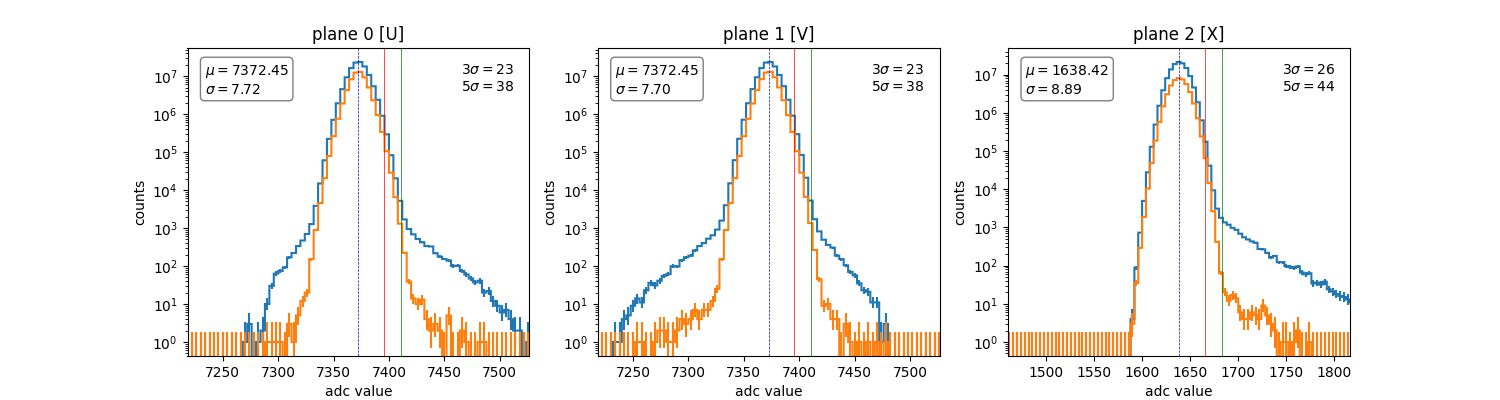

In [4]:

from rich.table import Table


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
view_range = 20
stat_x = 0.05
stat_y = 0.95
v_lw=0.5

thres_x = 0.8
thres_y = 0.95

# -- draw
fig,axes= plt.subplots(1,3, figsize=(15,4))


ax = axes[0]
adc_hists['ADCsPlaneU'].to_hist().plot(ax=ax)
adc_hists['ADCsNoisePlaneU'].to_hist().plot(ax=ax)
ax.set_xlabel('adc value')
ax.set_ylabel('counts')

mu, sigma = uproot_hist_mean_std(adc_hists['ADCsNoisePlaneU'])[0]
ax.set_xlim(mu-view_range*sigma, mu+view_range*sigma)
thrs_3s=mu+3*sigma
thrs_5s=mu+5*sigma

textstr = '\n'.join((
    f'$\\mu={mu:.2f}$',
    f'$\\sigma={sigma:.2f}$'))

# place a text box in top center in axes coords
ax.text(stat_x, stat_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

textstr = '\n'.join((
    f'$3\\sigma={int(3*sigma)}$',
    f'$5\\sigma={int(5*sigma)}$'
    ))
ax.text(thres_x, thres_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left')

ax.axvline(mu, color='b', ls='--', lw=v_lw)
ax.axvline(thrs_3s, color='r', lw=v_lw)
ax.axvline(thrs_5s, color='g', lw=v_lw)
ax.set_title('plane 0 [U]')

ax = axes[1]
adc_hists['ADCsPlaneV'].to_hist().plot(ax=ax)
adc_hists['ADCsNoisePlaneV'].to_hist().plot(ax=ax)
ax.set_xlabel('adc value')
ax.set_ylabel('counts')

mu, sigma = uproot_hist_mean_std(adc_hists['ADCsNoisePlaneV'])[0]
ax.set_xlim(mu-view_range*sigma, mu+view_range*sigma)
thrs_3s=mu+3*sigma
thrs_5s=mu+5*sigma

textstr = '\n'.join((
    f'$\\mu={mu:.2f}$',
    f'$\\sigma={sigma:.2f}$'))

# place a text box in top center in axes coords
ax.text(stat_x, stat_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

textstr = '\n'.join((
    f'$3\\sigma={int(3*sigma)}$',
    f'$5\\sigma={int(5*sigma)}$'
    ))
ax.text(thres_x, thres_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left')

ax.axvline(mu, color='b', ls='--', lw=v_lw)
ax.axvline(thrs_3s, color='r', lw=v_lw)
ax.axvline(thrs_5s, color='g', lw=v_lw)
ax.set_title('plane 1 [V]')


ax = axes[2]
adc_hists['ADCsPlaneX'].to_hist().plot(ax=ax)
adc_hists['ADCsNoisePlaneX'].to_hist().plot(ax=ax)
ax.set_xlabel('adc value')
ax.set_ylabel('counts')

mu, sigma = uproot_hist_mean_std(adc_hists['ADCsNoisePlaneX'])[0]
ax.set_xlim(mu-view_range*sigma, mu+view_range*sigma)
thrs_3s=mu+3*sigma
thrs_5s=mu+5*sigma

textstr = '\n'.join((
    f'$\\mu={mu:.2f}$',
    f'$\\sigma={sigma:.2f}$'))
# place a text box in top center in axes coords
ax.text(stat_x, stat_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

textstr = '\n'.join((
    f'$3\\sigma={int(3*sigma)}$',
    f'$5\\sigma={int(5*sigma)}$'
    ))
ax.text(thres_x, thres_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left')

ax.axvline(mu, color='b', ls='--', lw=v_lw)
ax.axvline(thrs_3s, color='r', lw=v_lw)
ax.axvline(thrs_5s, color='g', lw=v_lw)
ax.set_title('plane 2 [X]')

for ax in axes:
    ax.set_yscale("log")

### Utilities and helpers

In [5]:
class TPPreSelection:

    def __init__(self, tps):
        self.p0 = tps[tps.TP_plane == 0]
        self.p1 = tps[tps.TP_plane == 1]
        self.p2 = tps[tps.TP_plane == 2]


        self.sig_p0 = self.p0[self.p0.TP_signal == 1]
        self.sig_p1 = self.p1[self.p1.TP_signal == 1]
        self.sig_p2 = self.p2[self.p2.TP_signal == 1]

        self.noise_p0 = self.p0[self.p0.TP_signal == 0]
        self.noise_p1 = self.p1[self.p1.TP_signal == 0]
        self.noise_p2 = self.p2[self.p2.TP_signal == 0]

In [6]:

pool=None
with temporary_log_level(dp.TriggerPrimitivesWorkspace._log, logging.INFO):
    pool = dp.TriggerPrimitivesWorkspace("../data/vd/ar39/100events/tptree_st_tpg_vd_ar39.root")

print(pool.info)

<TTree 'ides_tree' (13 branches) at 0x00013acb74d0>


{
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'mc_generator_labels': ['Ar39GenInLAr'],
    'tpg': {
        'threshold_tpg_plane0': 23,
        'threshold_tpg_plane1': 23,
        'threshold_tpg_plane2': 26,
        'tool': 'TPAlgTPCSimpleThreshold'
    },
    'tptree': {'U_window_offset': 8, 'V_window_offset': 1, 'X_window_offset': -7}
}

In [7]:
all_tps = TPPreSelection(pool.tps)

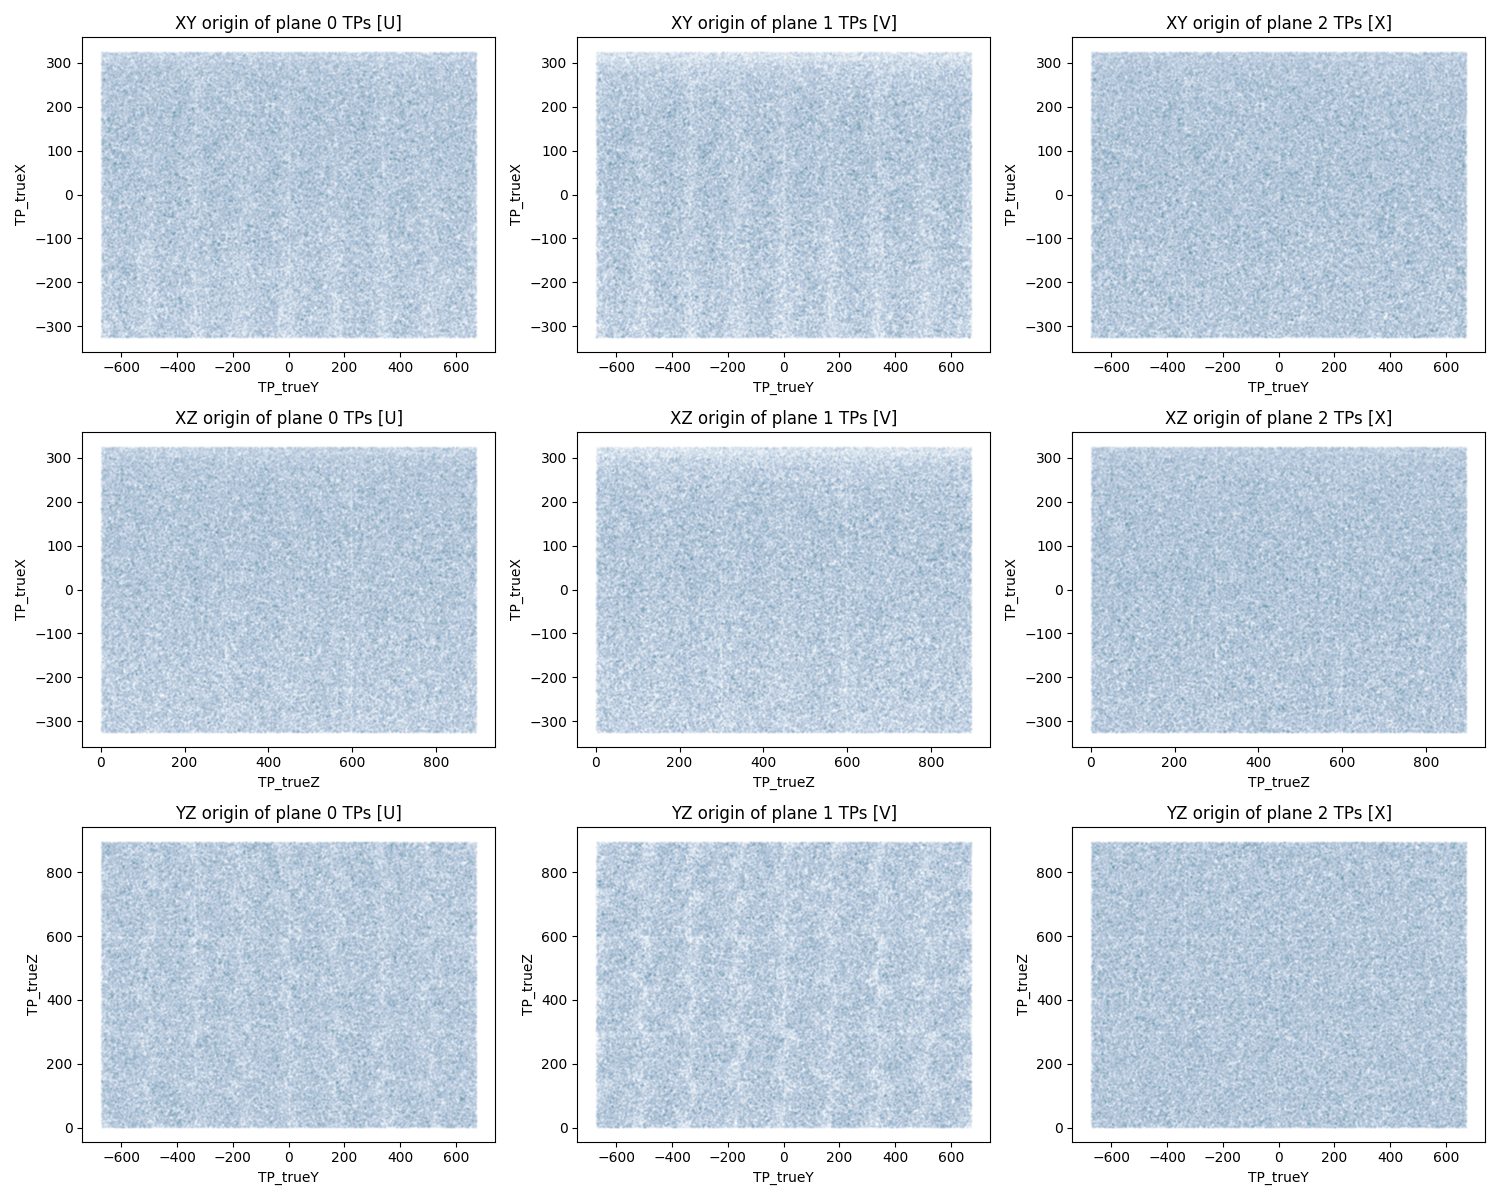

In [8]:
fig,axes= plt.subplots(3,3, figsize=(15,12))

# XY row
ax = axes[0][0]
all_tps.sig_p0.plot.scatter(x='TP_trueY', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XY origin of plane 0 TPs [U]')

ax = axes[0][1]
all_tps.sig_p1.plot.scatter(x='TP_trueY', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XY origin of plane 1 TPs [V]')

ax = axes[0][2]
all_tps.sig_p2.plot.scatter(x='TP_trueY', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XY origin of plane 2 TPs [X]')


# XZ row
ax = axes[1][0]
all_tps.sig_p0.plot.scatter(x='TP_trueZ', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XZ origin of plane 0 TPs [U]')

ax = axes[1][1]
all_tps.sig_p1.plot.scatter(x='TP_trueZ', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XZ origin of plane 1 TPs [V]')

ax = axes[1][2]
all_tps.sig_p2.plot.scatter(x='TP_trueZ', y='TP_trueX', alpha=0.01, s=1, ax=ax)
ax.set_title('XZ origin of plane 2 TPs [X]')

# YZ row
ax = axes[2][0]
all_tps.sig_p0.plot.scatter(x='TP_trueY', y='TP_trueZ', alpha=0.01, s=1, ax=ax)
ax.set_title('YZ origin of plane 0 TPs [U]')

ax = axes[2][1]
all_tps.sig_p1.plot.scatter(x='TP_trueY', y='TP_trueZ', alpha=0.01, s=1, ax=ax)
ax.set_title('YZ origin of plane 1 TPs [V]')

ax = axes[2][2]
all_tps.sig_p2.plot.scatter(x='TP_trueY', y='TP_trueZ', alpha=0.01, s=1, ax=ax)
ax.set_title('YZ origin of plane 2 TPs [X]')

fig.tight_layout()




Text(0, 0.5, 'counts')

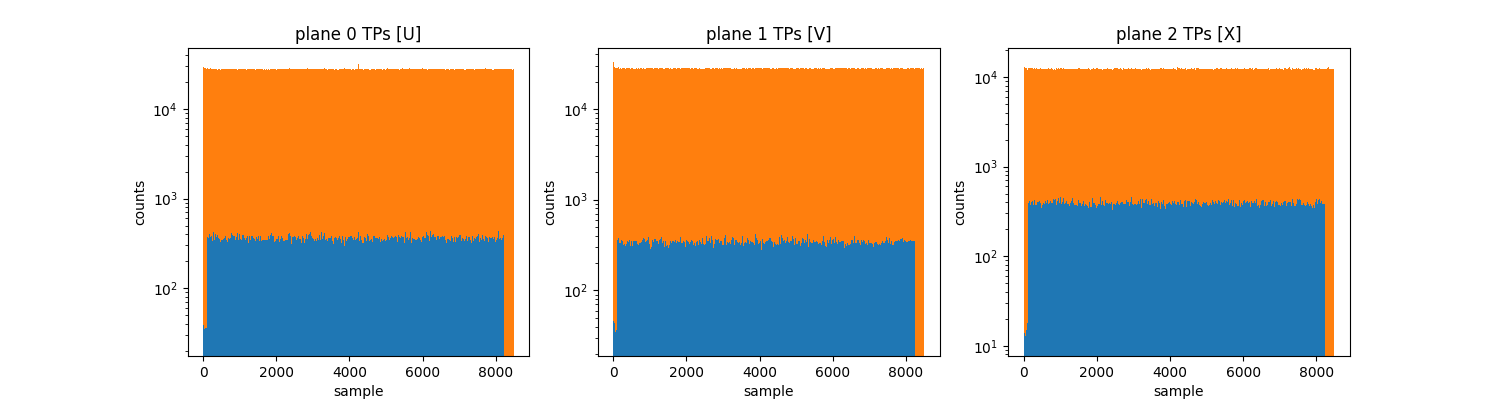

In [9]:
fig,axes= plt.subplots(1,3, figsize=(15,4))
tps=all_tps
n_bins=8500//8

ax=axes[0]
ax.hist([tps.sig_p0.TP_peakT,tps.noise_p0.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 0 TPs [U]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')

ax=axes[1]
ax.hist([tps.sig_p1.TP_peakT,tps.noise_p1.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 1 TPs [V]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')


ax=axes[2]
ax.hist([tps.sig_p2.TP_peakT,tps.noise_p2.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 2 TPs [X]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')


In [10]:
clean_tps = TPPreSelection(pool.tps[(pool.tps.TP_startT >100) & (pool.tps.TP_startT <8100)])

Text(0, 0.5, 'counts')

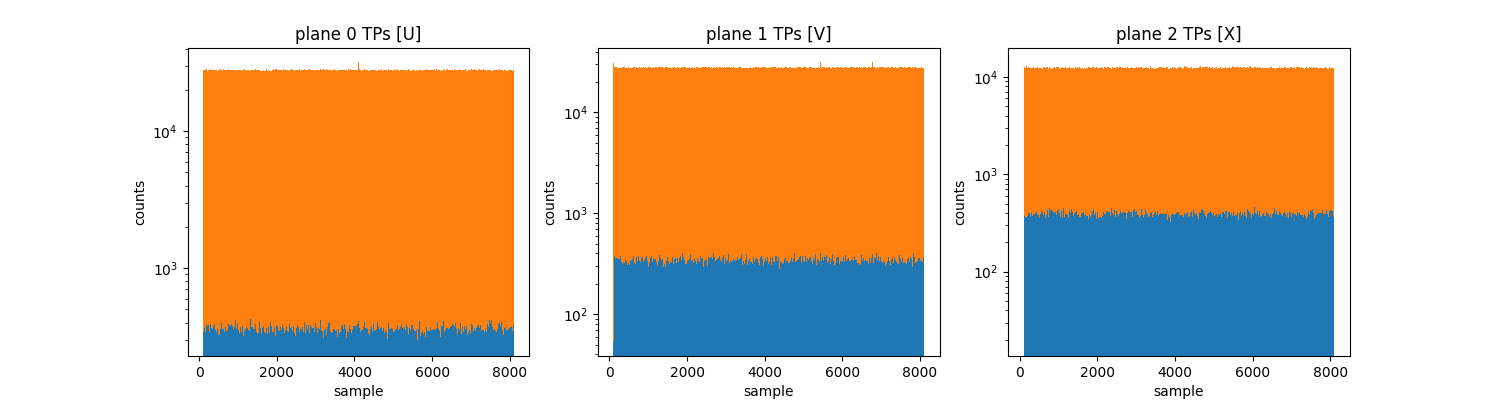

In [11]:
fig,axes= plt.subplots(1,3, figsize=(15,4))
tps=clean_tps
n_bins=8000//8

ax=axes[0]
ax.hist([tps.sig_p0.TP_peakT,tps.noise_p0.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 0 TPs [U]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')

ax=axes[1]
ax.hist([tps.sig_p1.TP_peakT,tps.noise_p1.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 1 TPs [V]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')


ax=axes[2]
ax.hist([tps.sig_p2.TP_peakT,tps.noise_p2.TP_peakT], stacked=True, bins=n_bins, log=True)
ax.set_title('plane 2 TPs [X]')
ax.set_xlabel('sample')
ax.set_ylabel('counts')


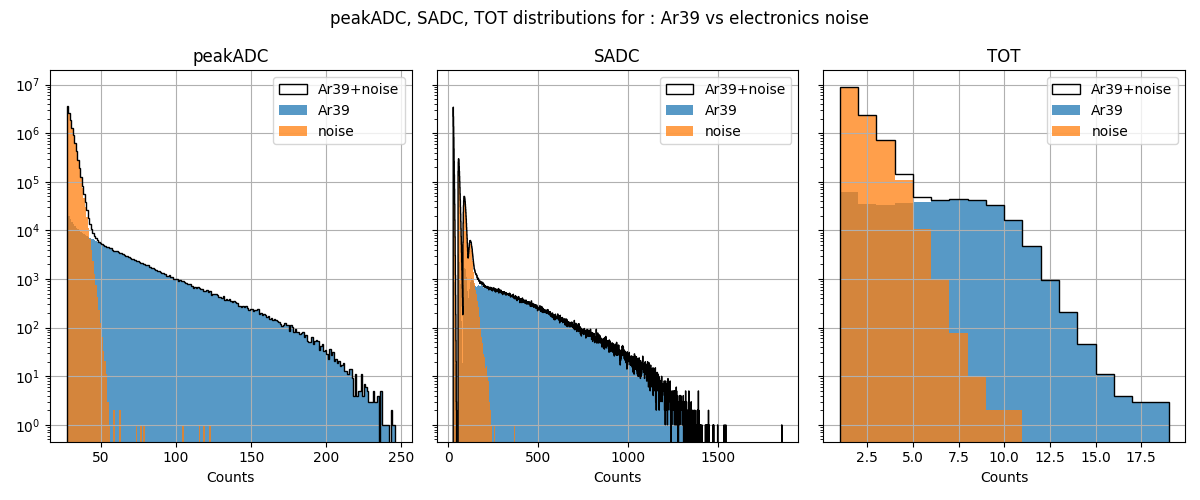

In [12]:
fig, axes= plt.subplots(1,3, figsize=(12,5), sharey=True)
tps=clean_tps

# var='peakADC'

var_list = ['peakADC', 'SADC', 'TOT']
for i,var in enumerate(var_list):
    col = f'TP_{var}'

    x_min=tps.p2[col].min()
    x_max=tps.p2[col].max()
    x_range=(x_max-x_min)
    n_bins=int(x_range)
    dx = x_range/n_bins
    bins = [ (x_min + i*dx) for i in range(n_bins+1)]
    ax=axes[i]
    tps.sig_p2[col].hist(bins=bins, ax=ax,log=True, alpha=0.75)
    ax.set_xlabel(f"Counts")
    tps.noise_p2[col].hist(bins=bins, ax=ax,log=True, alpha=0.75)
    tps.p2[col].hist(bins=bins, ax=ax, edgecolor='black', histtype='step', log=True)
    # ax.set_xlabel(f"{var}")
    ax.set_title(var)

    ax.legend(('Ar39+noise', 'Ar39', 'noise'))

fig.suptitle(f"{', '.join(var_list)} distributions for : Ar39 vs electronics noise")
fig.tight_layout()

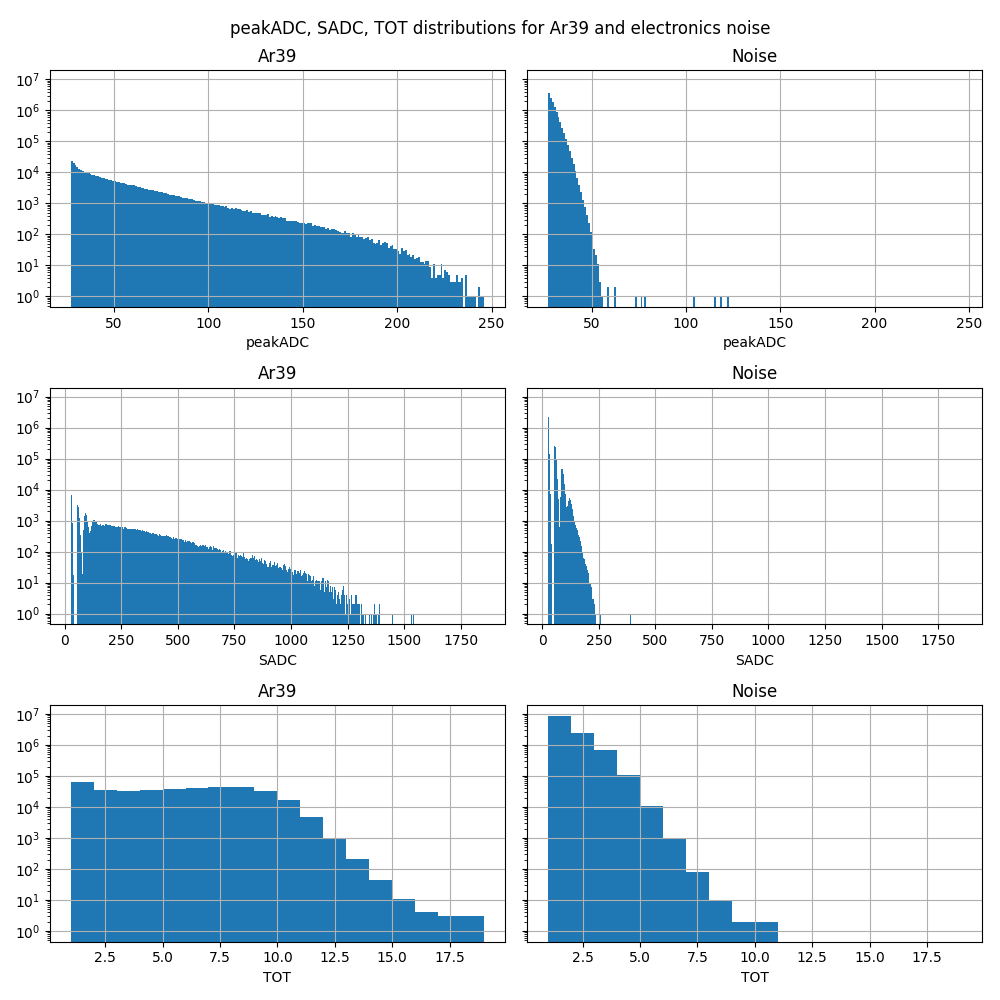

In [13]:
fig, axes= plt.subplots(3,2, figsize=(10,10), sharey=True)
tps=clean_tps

# var='peakADC'

var_list = ['peakADC', 'SADC', 'TOT']
for i,var in enumerate(var_list):
    col = f'TP_{var}'

    x_min=tps.p2[col].min()
    x_max=tps.p2[col].max()

    dx=(x_max-x_min)
    n_bins=int(dx)
    # n_bins=100

    binw = dx/n_bins
    bins = [ (x_min + i*binw) for i in range(n_bins+1)]

    ax=axes[i][0]
    tps.sig_p2[col].hist(bins=bins, ax=ax,log=True)
    ax.set_xlabel(f"{var}")
    ax.set_title("Ar39")
    ax = axes[i][1]
    tps.noise_p2[col].hist(bins=bins, ax=ax,log=True)
    ax.set_xlabel(f"{var}")
    ax.set_title("Noise")

fig.suptitle(f"{', '.join(var_list)} distributions for Ar39 and electronics noise")
fig.tight_layout()

## Look into distribution at different drift depths
### Collection plane only

In [14]:
# Split the dataset into bins by depth
g = clean_tps.sig_p2.groupby(pd.cut(clean_tps.sig_p2.TP_trueX, 30))

/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_80126/3615347551.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = clean_tps.sig_p2.groupby(pd.cut(clean_tps.sig_p2.TP_trueX, 30))


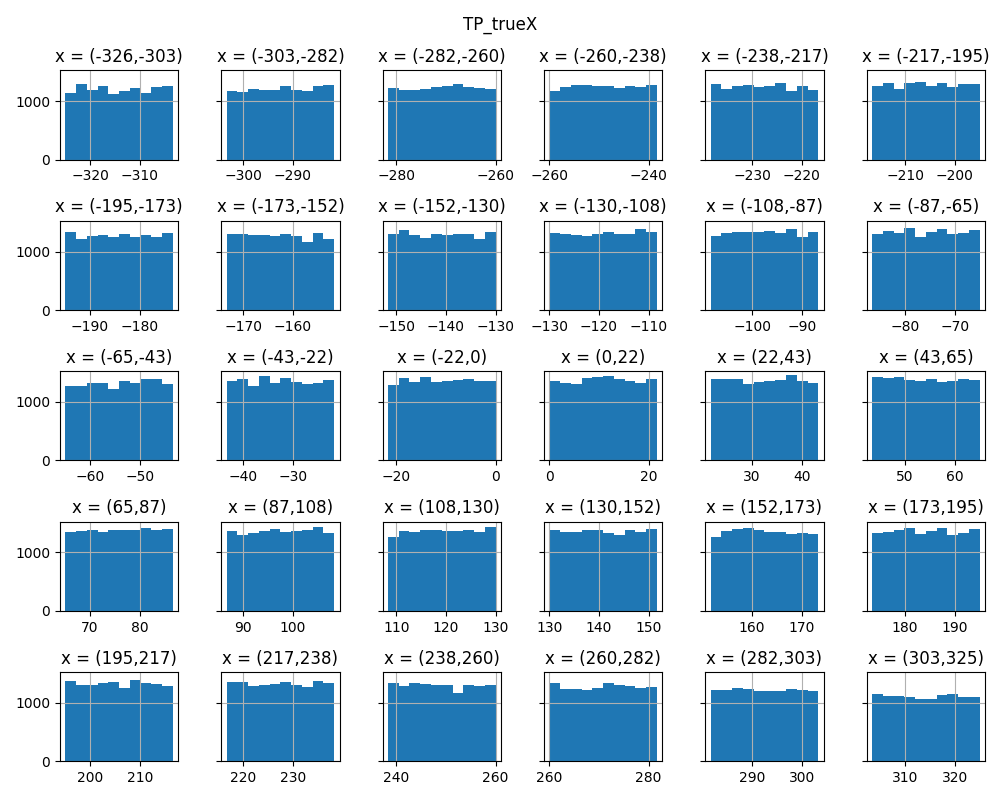

In [15]:
fig, axes = subplot_autogrid(len(g), figsize=(10,8), sharey=True)

var='trueX'

col=f'TP_{var}'

x_min=clean_tps.p2[col].min()
x_max=clean_tps.p2[col].max()

x_range=(x_max-x_min)
n_bins=int(x_range)//10
dx = x_range/n_bins

bins = [ (x_min + i*dx) for i in range(n_bins+1)]
bins=10

for k, (i, df) in enumerate(g):
    ax = axes[k]
    df[col].hist(bins=bins,ax=ax)
    ax.set_title(f"x = ({i.left:.0f},{i.right:.0f})")

fig.suptitle(col)

fig.tight_layout()

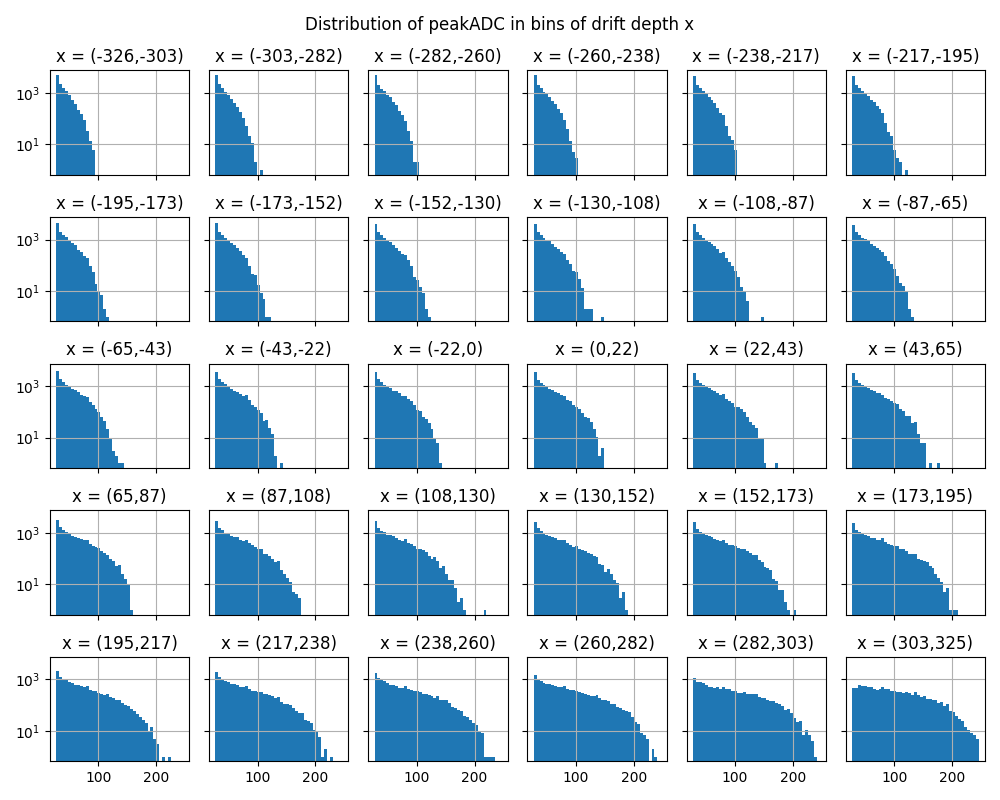

In [16]:
fig, axes = subplot_autogrid(len(g), figsize=(10,8), sharex=True, sharey=True)

var='peakADC'

col=f'TP_{var}'

x_min=clean_tps.p2[col].min()
x_max=clean_tps.p2[col].max()

x_range=(x_max-x_min)
n_bins=int(x_range)//5
dx = x_range/n_bins

bins = [ (x_min + i*dx) for i in range(n_bins+1)]

for k, (i, df) in enumerate(g):
    ax = axes[k]
    df[col].hist(bins=bins,ax=ax, log=True)
    ax.set_title(f"x = ({i.left:.0f},{i.right:.0f})")

fig.suptitle(f"Distribution of {var} in bins of drift depth x")

fig.tight_layout()

1825 36

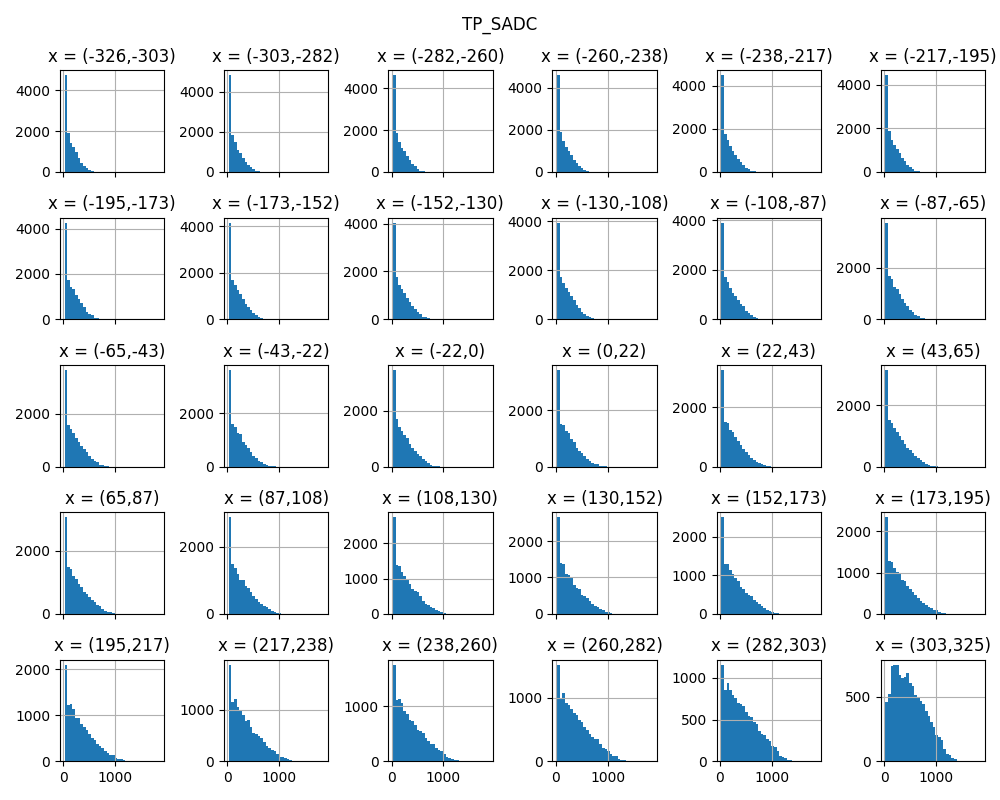

In [17]:
fig, axes = subplot_autogrid(len(g), figsize=(10,8), sharex=True)

var='SADC'

col=f'TP_{var}'

x_min=clean_tps.p2[col].min()
x_max=clean_tps.p2[col].max()

x_range=(x_max-x_min)
n_bins=int(x_range)//50
dx = x_range/n_bins

bins = [ (x_min + i*dx) for i in range(n_bins+1)]
print(x_range, n_bins)

for k, (i, df) in enumerate(g):
    ax = axes[k]
    df[col].hist(bins=bins,ax=ax)
    ax.set_title(f"x = ({i.left:.0f},{i.right:.0f})")

fig.suptitle(col)

fig.tight_layout()

18 18

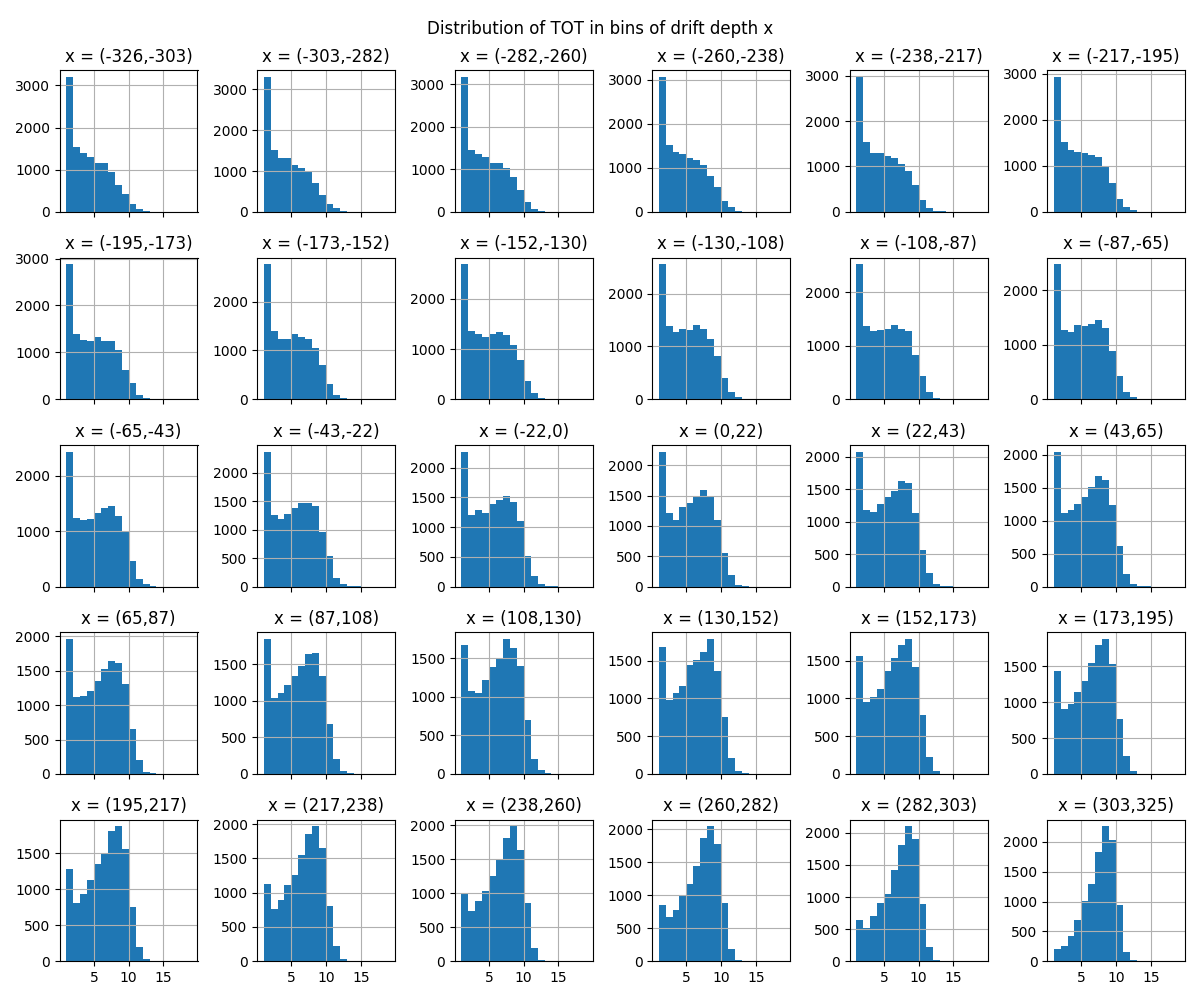

In [18]:
fig, axes = subplot_autogrid(len(g), figsize=(12,10), sharex=True)

var='TOT'

col=f'TP_{var}'

x_min=clean_tps.p2[col].min()
x_max=clean_tps.p2[col].max()

x_range=(x_max-x_min)
n_bins=int(x_range)//1
dx = x_range/n_bins

bins = [ (x_min + i*dx) for i in range(n_bins+1)]
print(x_range, n_bins)

for k, (i, df) in enumerate(g):
    ax = axes[k]
    df[col].hist(bins=bins,ax=ax)
    ax.set_title(f"x = ({i.left:.0f},{i.right:.0f})")

fig.suptitle(f"Distribution of {var} in bins of drift depth x")

fig.tight_layout()

In [19]:
n_ar39 = 0

for ev, g in pool.ides.groupby(by='event'):
    n_ar39 += len(g.track_id.unique())
print(n_ar39)

484267

In [20]:
pool.ides.groupby(by='event')['track_id'].nunique().sum()

np.int64(484267)

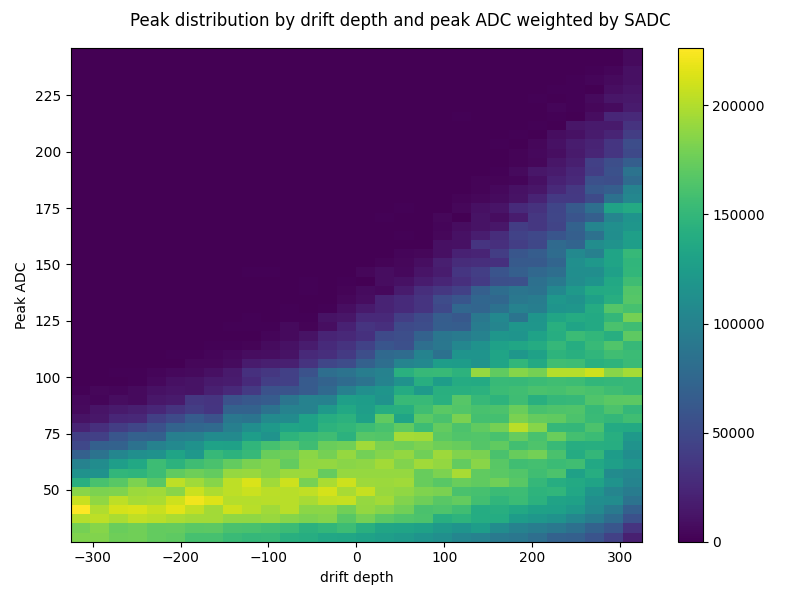

In [21]:
fig, ax= plt.subplots(1,1, figsize=(8,6))

n_bins_y = clean_tps.sig_p2.TP_peakADC.max()-clean_tps.sig_p2.TP_peakADC.min()
h2 = ax.hist2d(clean_tps.sig_p2.TP_trueX, clean_tps.sig_p2.TP_peakADC, weights=clean_tps.sig_p2.TP_SADC, bins=(30, n_bins_y//4))
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("drift depth")
ax.set_ylabel("Peak ADC")
fig.suptitle("Peak distribution by drift depth and peak ADC weighted by SADC")
fig.tight_layout()

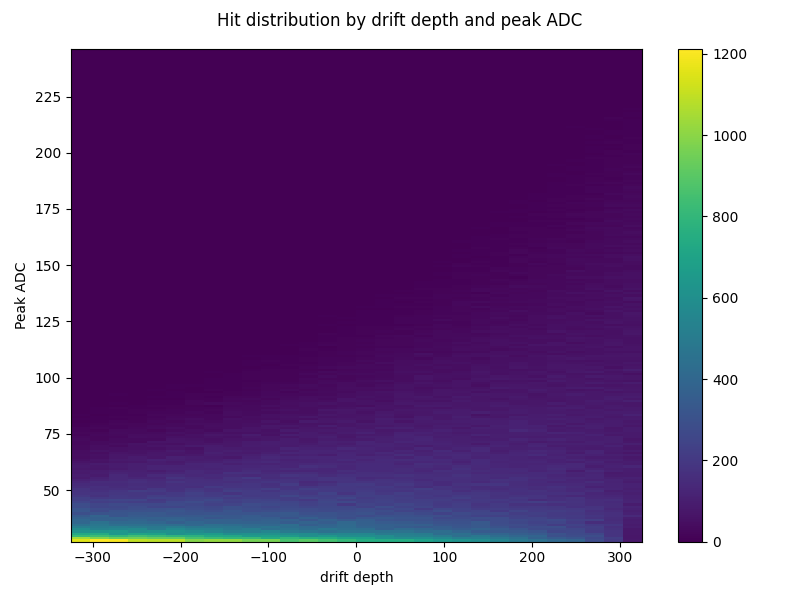

In [22]:
fig, ax= plt.subplots(1,1, figsize=(8,6))
tps = clean_tps

n_bins_y = tps.sig_p2.TP_peakADC.max()-tps.sig_p2.TP_peakADC.min()
h2 = ax.hist2d(tps.sig_p2.TP_trueX, tps.sig_p2.TP_peakADC, bins=(30, n_bins_y//1))
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("drift depth")
ax.set_ylabel("Peak ADC")
fig.suptitle("Hit distribution by drift depth and peak ADC")
fig.tight_layout()

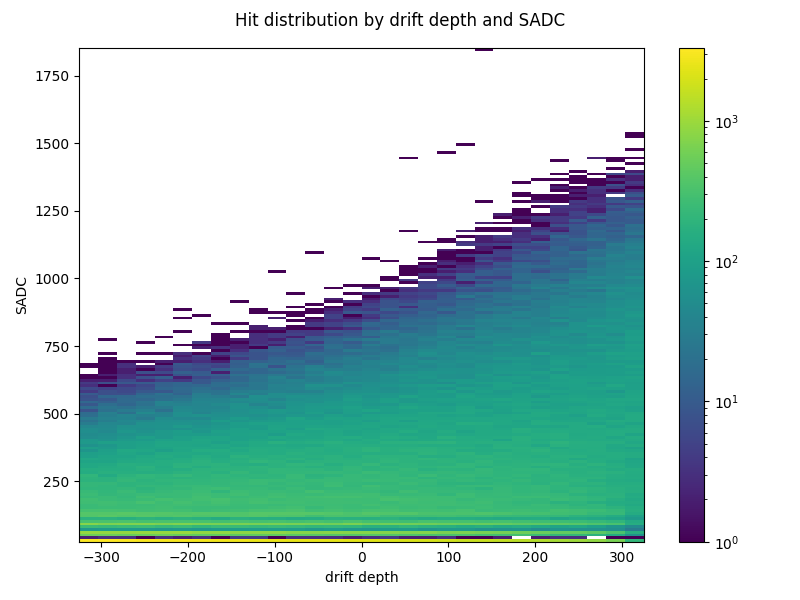

In [23]:
fig, ax= plt.subplots(1,1, figsize=(8,6))

norm=mpl.colors.LogNorm()
tps = clean_tps


n_bins_peak = tps.sig_p2.TP_SADC.max()-tps.sig_p2.TP_SADC.min()
h2 = ax.hist2d(tps.sig_p2.TP_trueX, tps.sig_p2.TP_SADC, bins=(30, n_bins_peak//10), norm=norm)
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("drift depth")
ax.set_ylabel("SADC")
fig.suptitle("Hit distribution by drift depth and SADC")
fig.tight_layout()

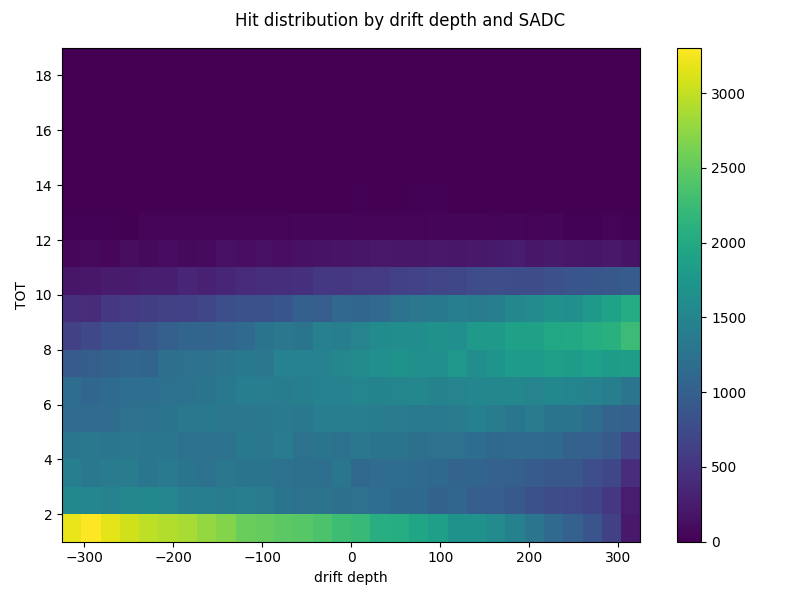

In [24]:
fig, ax= plt.subplots(1,1, figsize=(8,6))
tps = clean_tps

n_bins_y = tps.sig_p2.TP_TOT.max()-tps.sig_p2.TP_TOT.min()
h2 = ax.hist2d(tps.sig_p2.TP_trueX, tps.sig_p2.TP_TOT, bins=(30, n_bins_y//1))
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("drift depth")
ax.set_ylabel("TOT")
fig.suptitle("Hit distribution by drift depth and SADC")
fig.tight_layout()

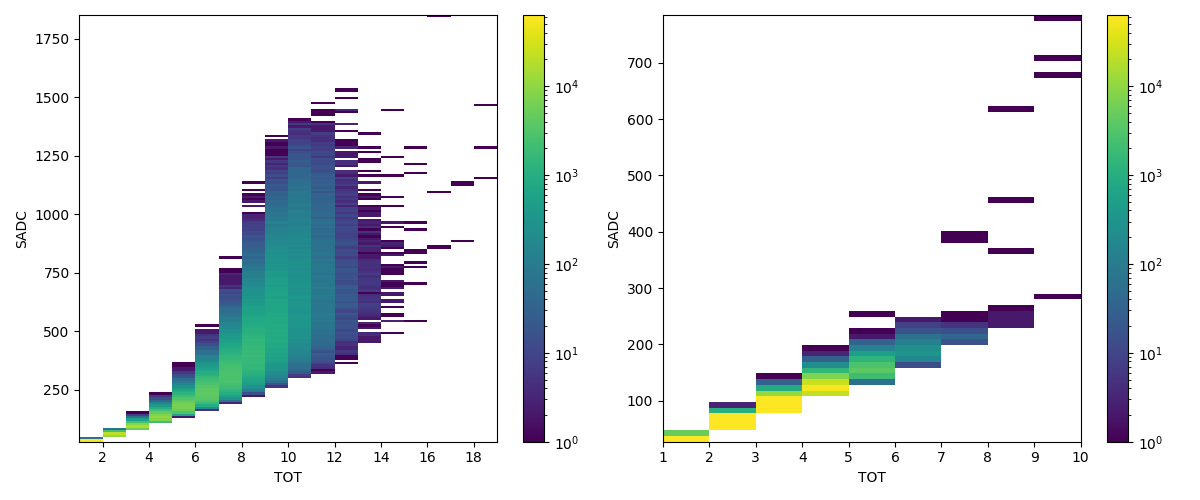

In [25]:
import matplotlib as mpl
fig, axes= plt.subplots(1,2, figsize=(12,5))
# clean_tps.sig_p2[clean_tps.sig_p2.TP_peakADC < 150].TP_trueX.hist(bins=30)

norm=mpl.colors.LogNorm()

ax = axes[0]
n_bins_y = clean_tps.sig_p2.TP_SADC.max()-clean_tps.sig_p2.TP_SADC.min()
n_bins_x = clean_tps.sig_p2.TP_TOT.max()-clean_tps.sig_p2.TP_TOT.min()
h2 = ax.hist2d(clean_tps.sig_p2.TP_TOT, clean_tps.sig_p2.TP_SADC, bins=(n_bins_x, n_bins_y//10), norm=norm)
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("TOT")
ax.set_ylabel("SADC")
# fig.suptitle("Hit distribution by drift depth and SADC")

ax = axes[1]
n_bins_y = clean_tps.noise_p2.TP_SADC.max()-clean_tps.noise_p2.TP_SADC.min()
n_bins_x = clean_tps.noise_p2.TP_TOT.max()-clean_tps.noise_p2.TP_TOT.min()
h2 = ax.hist2d(clean_tps.noise_p2.TP_TOT, clean_tps.noise_p2.TP_SADC, bins=(n_bins_x, n_bins_y//10), norm=norm)
fig.colorbar(h2[3], ax=ax)
ax.set_xlabel("TOT")
ax.set_ylabel("SADC")

fig.tight_layout()

Text(0.5, 0.98, 'TP drift depth of origin by ADC peak range')

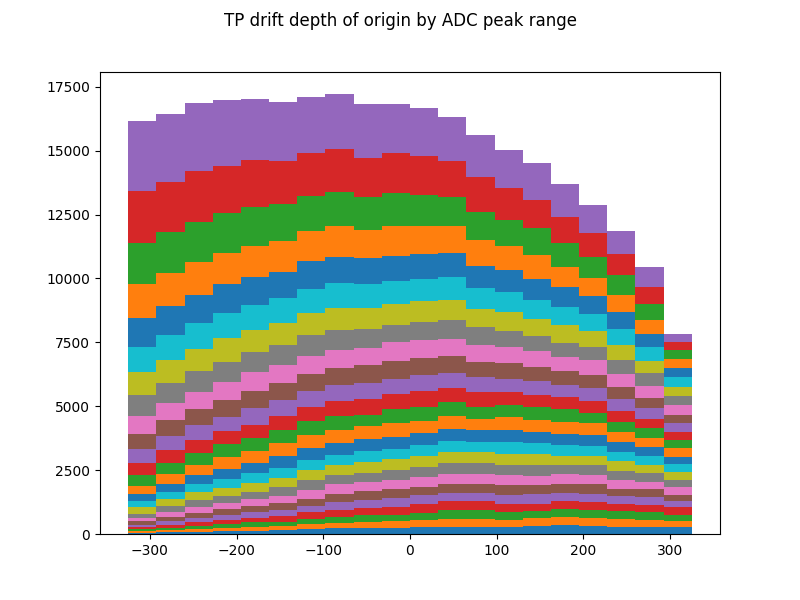

In [26]:
fig, ax= plt.subplots(1,1, figsize=(8,6))

tps_p2 = clean_tps.sig_p2
th_0=tps_p2.TP_peakADC.min()

bins= [k for k in range(th_0,th_0+50,2)]

step = 2
hists = [
    tps_p2[
        (tps_p2.TP_peakADC > k) &
        (tps_p2.TP_peakADC <= k+2)
    ].TP_trueX
    for k in bins
    ]

h = ax.hist(
    list(reversed(hists)),
    bins=20,
    density=False,
    stacked=True,
)

fig.suptitle("TP drift depth of origin by ADC peak range")

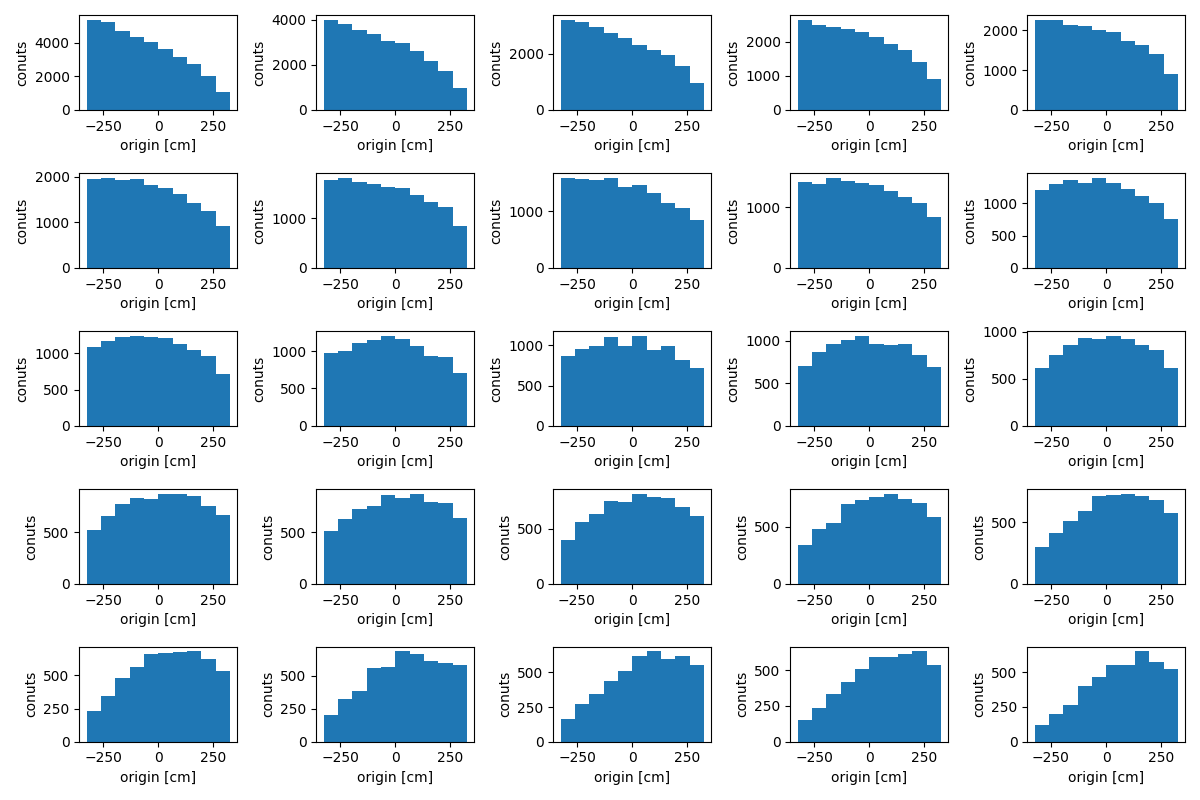

In [27]:
fig, axes = subplot_autogrid(len(hists), figsize=(12,8))


for i,h in enumerate(hists):
    ax=axes[i]
    ax.hist(h)
    ax.set_xlabel('origin [cm]')
    ax.set_ylabel('conuts')


fig.tight_layout()

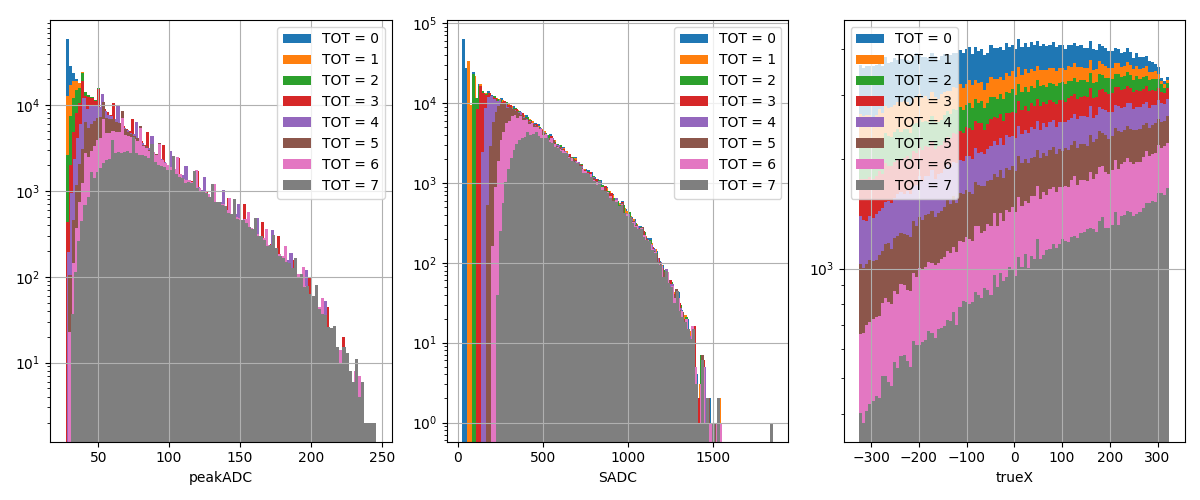

In [28]:
fig, axes = plt.subplots(1,3, figsize=(12,5))

tot_cuts = [t for t in range(8)]

for TOT_th in tot_cuts:
    ax=axes[0]
    clean_tps.sig_p2[clean_tps.sig_p2.TP_TOT >TOT_th].TP_peakADC.hist(ax=ax, bins=100)
    ax=axes[1]
    clean_tps.sig_p2[clean_tps.sig_p2.TP_TOT >TOT_th].TP_SADC.hist(ax=ax, bins=100)
    ax=axes[2]
    clean_tps.sig_p2[clean_tps.sig_p2.TP_TOT >TOT_th].TP_trueX.hist(ax=ax, bins=100)

for i,l in enumerate(['peakADC', 'SADC', 'trueX']):
    axes[i].set_xlabel(l)
    axes[i].legend([f"TOT = {t}" for t in tot_cuts])
    axes[i].set_yscale("log")

fig.tight_layout()

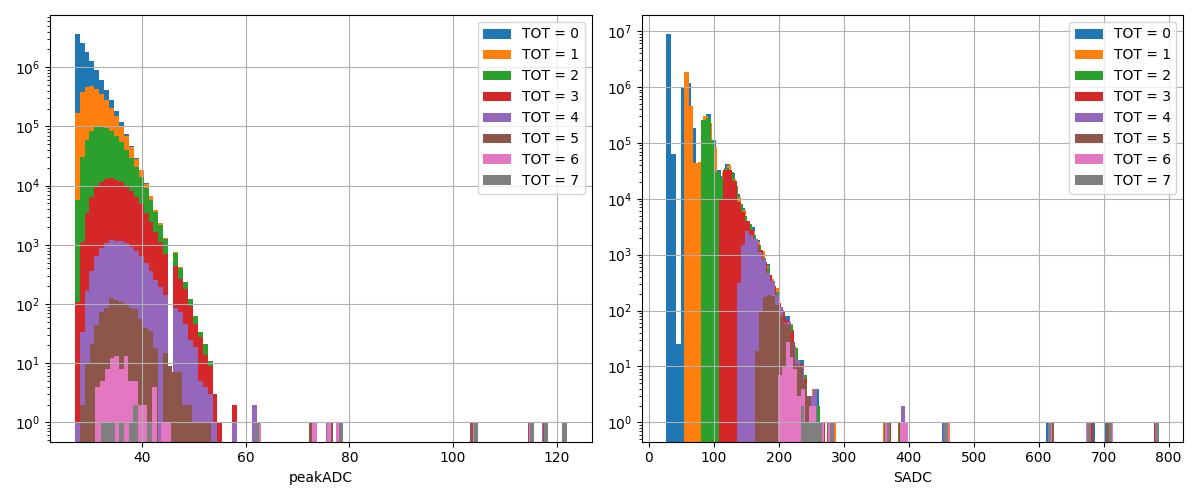

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

tot_cuts = [t for t in range(8)]

for TOT_th in range(8):
    ax=axes[0]
    clean_tps.noise_p2[clean_tps.noise_p2.TP_TOT >TOT_th].TP_peakADC.hist(ax=ax, bins=100)
    ax=axes[1]
    clean_tps.noise_p2[clean_tps.noise_p2.TP_TOT >TOT_th].TP_SADC.hist(ax=ax, bins=100)

for i,l in enumerate(['peakADC', 'SADC']):
    axes[i].set_xlabel(l)
    axes[i].legend([f"TOT = {t}" for t in tot_cuts])
    axes[i].set_yscale("log")

fig.tight_layout()

In [37]:
import pandas as pd 


thresholds = [t for t in range(26, 120, 1)]
tps=clean_tps


n_sig_tps = [len(tps.sig_p2[(tps.sig_p2.TP_peakADC > t)]) for t in thresholds]
n_noise_tps = [len(tps.noise_p2[(tps.noise_p2.TP_peakADC > t)]) for t in thresholds]
rate_sig_tps = [utils.df_to_TP_rates(tps.sig_p2[(tps.sig_p2.TP_peakADC > t)]) for t in thresholds]
rate_noise_tps = [utils.df_to_TP_rates(tps.noise_p2[(tps.noise_p2.TP_peakADC > t)]) for t in thresholds]


df = pd.DataFrame({
    'threshold': thresholds,
    'n_sig': n_sig_tps,
    'n_noise': n_noise_tps,
    'rate_sig': rate_sig_tps,
    'rate_noise': rate_noise_tps
})

df['n_tot'] = df.n_sig + df.n_noise
df['rate_tot'] = df.rate_sig + df.rate_noise
display(df)

threshold   n_sig   n_noise       rate_sig    rate_noise     n_tot  \
0          26  391013  11972699  979681.676678  2.993500e+07  12363712   
1          27  368261   8379982  922872.007177  2.095223e+07   8748243   
2          28  348892   5800268  874477.406936  1.450227e+07   6149160   
3          29  331984   3971812  832196.528169  9.930709e+06   4303796   
4          30  316935   2685636  794516.461395  6.715022e+06   3002571   
..        ...     ...       ...            ...           ...       ...   
89        115   20035         2   50747.470859  0.000000e+00     20037   
90        116   19397         2   49140.976613  0.000000e+00     19399   
91        117   18770         2   47568.784031  0.000000e+00     18772   
92        118   18193         1   46117.304699  0.000000e+00     18194   
93        119   17627         1   44695.074718  0.000000e+00     17628   

        rate_tot  
0   3.091468e+07  
1   2.187511e+07  
2   1.537674e+07  
3   1.076291e+07  
4   7.509538e+06  
..           ...  
89  5.074747e+04  
90  4.914098e+04  
91  4.756878e+04  
92  4.611730e+04  
93  4.469507e+04  

[94 rows x 7 columns]

threshold   n_sig   n_noise       rate_sig    rate_noise     n_tot  \
0          26  391013  11972699  979681.676678  2.993500e+07  12363712   
1          27  368261   8379982  922872.007177  2.095223e+07   8748243   
2          28  348892   5800268  874477.406936  1.450227e+07   6149160   
3          29  331984   3971812  832196.528169  9.930709e+06   4303796   
4          30  316935   2685636  794516.461395  6.715022e+06   3002571   
..        ...     ...       ...            ...           ...       ...   
89        115   20035         2   50747.470859  0.000000e+00     20037   
90        116   19397         2   49140.976613  0.000000e+00     19399   
91        117   18770         2   47568.784031  0.000000e+00     18772   
92        118   18193         1   46117.304699  0.000000e+00     18194   
93        119   17627         1   44695.074718  0.000000e+00     17628   

        rate_tot  sig_frac    noise_frac  noise_dominance    purity  \
0   3.091468e+07  1.000000  1.000000e+00        30.619696  0.031626   
1   2.187511e+07  0.941813  6.999242e-01        22.755551  0.042095   
2   1.537674e+07  0.892277  4.844578e-01        16.624824  0.056738   
3   1.076291e+07  0.849036  3.317391e-01        11.963866  0.077137   
4   7.509538e+06  0.810548  2.243133e-01         8.473775  0.105555   
..           ...       ...           ...              ...       ...   
89  5.074747e+04  0.051239  1.670467e-07         0.000100  0.999900   
90  4.914098e+04  0.049607  1.670467e-07         0.000103  0.999897   
91  4.756878e+04  0.048004  1.670467e-07         0.000107  0.999893   
92  4.611730e+04  0.046528  8.352336e-08         0.000055  0.999945   
93  4.469507e+04  0.045080  8.352336e-08         0.000057  0.999943   

    completeness  
0       1.000000  
1       0.941813  
2       0.892277  
3       0.849036  
4       0.810548  
..           ...  
89      0.051239  
90      0.049607  
91      0.048004  
92      0.046528  
93      0.045080  

[94 rows x 12 columns]

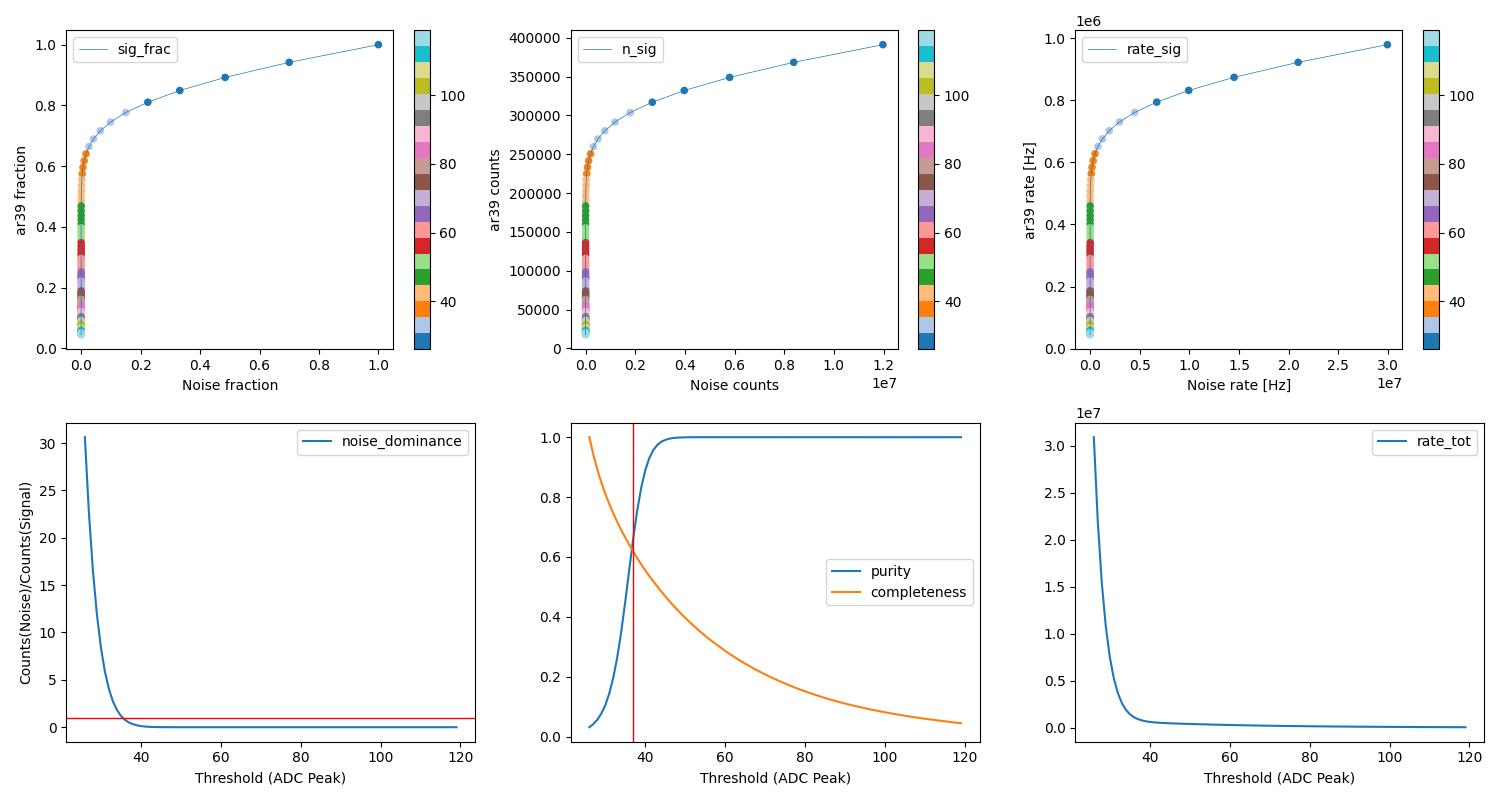

In [39]:
fig,axes= plt.subplots(2,3, figsize=(15,8))

df['sig_frac'] = df.n_sig/len(clean_tps.sig_p2)
df['noise_frac'] = df.n_noise/len(clean_tps.noise_p2)
df['noise_dominance'] = df.n_noise/df.n_sig
df['purity'] = df.n_sig/(df.n_noise+df.n_sig)
df['completeness'] = df.n_sig/len(clean_tps.sig_p2)

cmap='tab20'

ax=axes[0][0]
df.plot(x='noise_frac', y='sig_frac', lw=0.5,  ax=ax)
df.plot.scatter(x='noise_frac', y='sig_frac', c=df.threshold, cmap='tab20', ax=ax)
ax.set_ylabel('ar39 fraction')
ax.set_xlabel('Noise fraction')
ax=axes[0][1]
df.plot(x='n_noise', y='n_sig', lw=0.5,  ax=ax)
df.plot.scatter(x='n_noise', y='n_sig', c=df.threshold,  cmap='tab20', ax=ax)
ax.set_ylabel('ar39 counts')
ax.set_xlabel('Noise counts')
ax=axes[0][2]
df.plot(x='rate_noise', y='rate_sig', lw=0.5,  ax=ax)
df.plot.scatter(x='rate_noise', y='rate_sig', c=df.threshold, cmap='tab20', ax=ax)

ax.set_ylabel('ar39 rate [Hz]')
ax.set_xlabel('Noise rate [Hz]')
ax=axes[1][0]
df.plot(x='threshold', y='noise_dominance', ax=ax)
ax.axhline(1, color='r', lw=1)
ax.set_xlabel('Threshold (ADC Peak)')
ax.set_ylabel('Counts(Noise)/Counts(Signal)')
ax=axes[1][1]
df.plot(x='threshold', y='purity', ax=ax)
df.plot(x='threshold', y='completeness', ax=ax)
ax.set_xlabel('Threshold (ADC Peak)')

ax.axvline(37, color='r', lw=1)
ax=axes[1][2]
df.plot(x='threshold', y='rate_tot', ax=ax)
ax.set_xlabel('Threshold (ADC Peak)')


display(df)

fig.tight_layout()


In [41]:
import pandas as pd 


thresholds = [t for t in range(1,10, 1)]
tps=clean_tps
var='TP_TOT'

n_sig_tps = [len(tps.sig_p2[(tps.sig_p2[var] > t)]) for t in thresholds]
n_noise_tps = [len(tps.noise_p2[(tps.noise_p2[var] > t)]) for t in thresholds]
rate_sig_tps = [utils.df_to_TP_rates(tps.sig_p2[(tps.sig_p2[var] > t)]) for t in thresholds]
rate_noise_tps = [utils.df_to_TP_rates(tps.noise_p2[(tps.noise_p2[var] > t)]) for t in thresholds]


df = pd.DataFrame({
    'threshold': thresholds,
    'n_sig': n_sig_tps,
    'n_noise': n_noise_tps,
    'rate_sig': rate_sig_tps,
    'rate_noise': rate_noise_tps
})

df['n_tot'] = df.n_sig + df.n_noise
df['rate_tot'] = df.rate_sig + df.rate_noise
display(df)

threshold   n_sig  n_noise       rate_sig    rate_noise    n_tot  \
0          1  327831  3185931  821729.403876  7.965903e+06  3513762   
1          2  293476   807252  735779.614104  2.018819e+06  1100728   
2          3  259732   121582  651281.401900  3.044661e+05   381314   
3          4  223656    11818  560854.813593  3.005668e+04   235474   
4          5  185015     1049  463993.278913  3.235662e+03   186064   
5          6  143448       91  359838.954458  2.364711e+03   143539   
6          7   98818       14  248042.440665  0.000000e+00    98832   
7          8   55631        4  139874.786282  0.000000e+00    55635   
8          9   22399        2   56683.799098  0.000000e+00    22401   

       rate_tot  
0  8.787632e+06  
1  2.754599e+06  
2  9.557475e+05  
3  5.909115e+05  
4  4.672289e+05  
5  3.622037e+05  
6  2.480424e+05  
7  1.398748e+05  
8  5.668380e+04

threshold   n_sig  n_noise       rate_sig    rate_noise    n_tot  \
0          1  327831  3185931  821729.403876  7.965903e+06  3513762   
1          2  293476   807252  735779.614104  2.018819e+06  1100728   
2          3  259732   121582  651281.401900  3.044661e+05   381314   
3          4  223656    11818  560854.813593  3.005668e+04   235474   
4          5  185015     1049  463993.278913  3.235662e+03   186064   
5          6  143448       91  359838.954458  2.364711e+03   143539   
6          7   98818       14  248042.440665  0.000000e+00    98832   
7          8   55631        4  139874.786282  0.000000e+00    55635   
8          9   22399        2   56683.799098  0.000000e+00    22401   

       rate_tot  sig_frac    noise_frac  noise_dominance    purity  \
0  8.787632e+06  0.838415  2.660996e-01         9.718212  0.093299   
1  2.754599e+06  0.750553  6.742440e-02         2.750658  0.266620   
2  9.557475e+05  0.664254  1.015494e-02         0.468106  0.681150   
3  5.909115e+05  0.571991  9.870790e-04         0.052840  0.949812   
4  4.672289e+05  0.473168  8.761600e-05         0.005670  0.994362   
5  3.622037e+05  0.366862  7.600625e-06         0.000634  0.999366   
6  2.480424e+05  0.252723  1.169327e-06         0.000142  0.999858   
7  1.398748e+05  0.142274  3.340934e-07         0.000072  0.999928   
8  5.668380e+04  0.057285  1.670467e-07         0.000089  0.999911   

   completeness  
0      0.838415  
1      0.750553  
2      0.664254  
3      0.571991  
4      0.473168  
5      0.366862  
6      0.252723  
7      0.142274  
8      0.057285

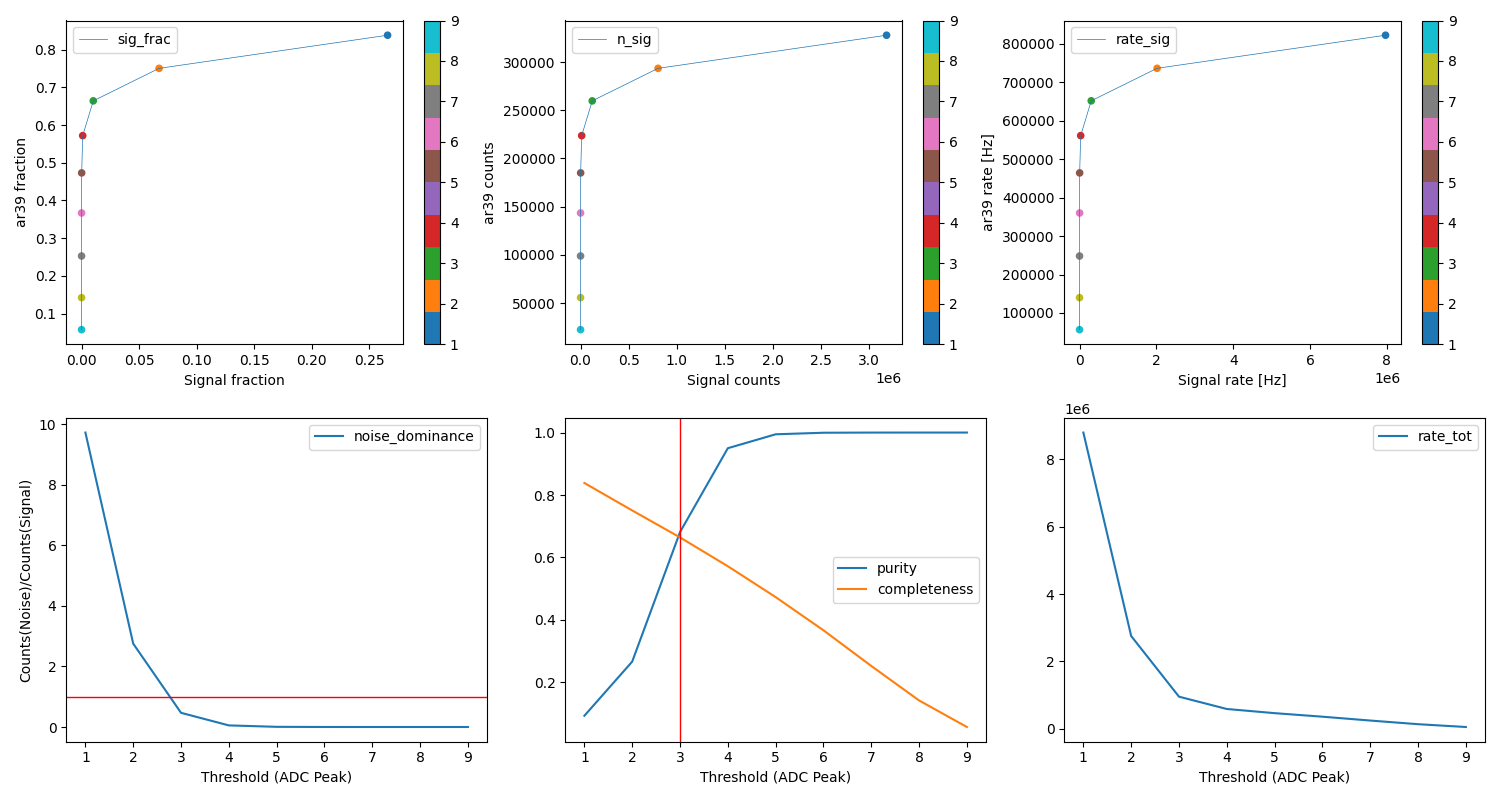

In [42]:
fig,axes= plt.subplots(2,3, figsize=(15,8))

df['sig_frac'] = df.n_sig/len(clean_tps.sig_p2)
df['noise_frac'] = df.n_noise/len(clean_tps.noise_p2)
df['noise_dominance'] = df.n_noise/df.n_sig
df['purity'] = df.n_sig/(df.n_noise+df.n_sig)
df['completeness'] = df.n_sig/len(clean_tps.sig_p2)

cmap='tab10'



ax=axes[0][0]
df.plot(x='noise_frac', y='sig_frac', lw=0.5,  ax=ax)
df.plot.scatter(x='noise_frac', y='sig_frac', c=df.threshold, cmap=cmap, ax=ax)
ax.set_ylabel('ar39 fraction')
ax.set_xlabel('Signal fraction')
ax=axes[0][1]
df.plot(x='n_noise', y='n_sig', lw=0.5,  ax=ax)
df.plot.scatter(x='n_noise', y='n_sig', c=df.threshold,  cmap=cmap, ax=ax)
ax.set_ylabel('ar39 counts')
ax.set_xlabel('Signal counts')
ax=axes[0][2]
df.plot(x='rate_noise', y='rate_sig', lw=0.5,  ax=ax)
df.plot.scatter(x='rate_noise', y='rate_sig', c=df.threshold, cmap=cmap, ax=ax)

ax.set_ylabel('ar39 rate [Hz]')
ax.set_xlabel('Signal rate [Hz]')
ax=axes[1][0]
df.plot(x='threshold', y='noise_dominance', ax=ax)
ax.axhline(1, color='r', lw=1)
ax.set_xlabel('Threshold (ADC Peak)')
ax.set_ylabel('Counts(Noise)/Counts(Signal)')
ax=axes[1][1]
df.plot(x='threshold', y='purity', ax=ax)
df.plot(x='threshold', y='completeness', ax=ax)
ax.set_xlabel('Threshold (ADC Peak)')

ax.axvline(3, color='r', lw=1)
ax=axes[1][2]
df.plot(x='threshold', y='rate_tot', ax=ax)
ax.set_xlabel('Threshold (ADC Peak)')


display(df)

fig.tight_layout()